As a starting point for our moseq-based analyses, want to be able to run `kpms` based on the GIMBAL keypoints in Mo's dataset

In [2]:
import kpsn_moseq_explore.lib.kpms_custom_io as cio
from kpsn_moseq_explore import lib
import numpy as np
import joblib as jl
import glob, os

In [3]:
import keypoint_moseq as kpms

dataset = 'blscale_wk3_to52'
# dataset = 'twoscale_wk5'
root_dir = '/home/kaf200/datta/kai/mph/moseq-explore'

project_dir = f'{root_dir}/kpms_projects/{dataset}'
data_dir = f'{root_dir}/recordings/modata'
results_dir = lambda: f'{root_dir}/kpms_results/{dataset}/{model_name}'

if not os.path.isdir(project_dir):
    print(f"Warning: project directory does not exist:\n{project_dir}")

config = lambda: kpms.load_config(project_dir)

In [4]:
bodyparts=[
    'shldr', 'back', 'hips',
    't_base', 't_tip',
    'head', 'l_ear', 'r_ear', 'nose',
    'lr_knee', 'lr_foot',
    'rr_knee', 'rr_foot',
    'lf_foot', 'rf_foot']

skeleton_ixs = [0,0,1,2,3,0,5,5,5,2,9,2,11,0,0]
skeleton=[
    [bodyparts[start_ix], bodyparts[end_ix]]
    for start_ix, end_ix in enumerate(skeleton_ixs)][1:]

kpms.setup_project(
    project_dir,
    overwrite = True,
    bodyparts = bodyparts,
    skeleton = skeleton,
    anterior_bodyparts = ['hips'],
    posterior_bodyparts = ['shldr'],
    use_bodyparts = [
        'shldr', 'back', 'hips', 't_base',
        'head', 'l_ear', 'r_ear', 'nose',
    ])

In [5]:
if dataset == 'modata':
    data, metadata = lib.datasets.modata(data_dir, config())

if dataset.startswith('twoscale_wk'):
    data, metadata = lib.datasets.twoscale(dataset, data_dir, config())

if dataset.startswith("multiscale_wk"):
    data, metadata = lib.datasets.multiscale(dataset, data_dir, config())

if dataset.startswith('blscale_wk'):
    data, metadata = lib.datasets.blscale(dataset, data_dir, config())

Cohort: 3wk
Target: 52wk


Loading keypoints: 100%|██████████████████| 6/6 [00:00<00:00, 56.07it/s]


##### PCA

>=90.0% of variance exlained by 3 components.


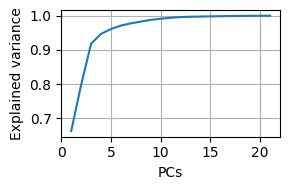

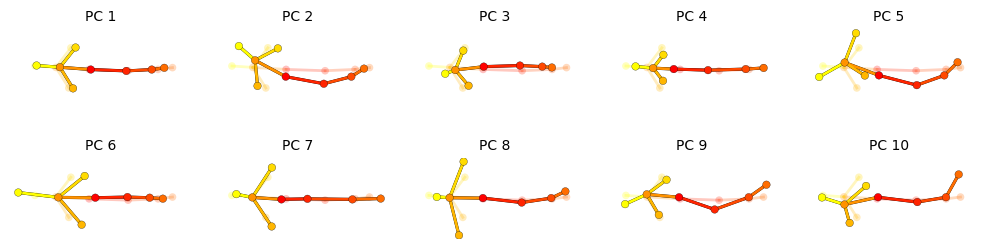

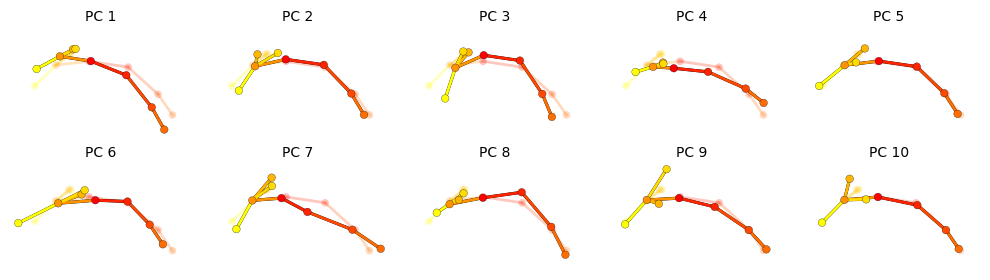

Saved interactive plot to /home/kaf200/datta/kai/mph/moseq-explore/kpms_projects/blscale_wk3_to52/pcs.html


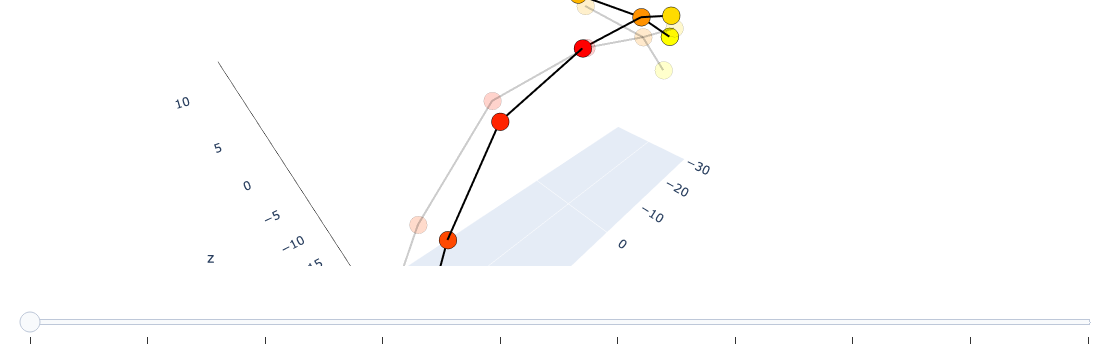

In [6]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())


In [7]:
kpms.update_config(project_dir, latent_dim=4)

### Fitting

In [39]:
model = kpms.init_model(data, pca=pca, **config())

Outputs will be saved to /home/kaf200/datta/kai/mph/moseq-
explore/kpms_projects/blscale_wk3_to52/arhmm_fit


 49%|█████████████████▏                 | 25/51 [01:07<01:10,  2.69s/it]

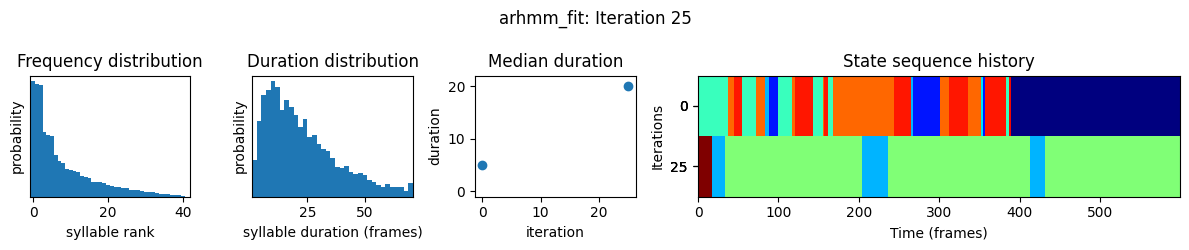

 98%|██████████████████████████████████▎| 50/51 [02:15<00:02,  2.71s/it]

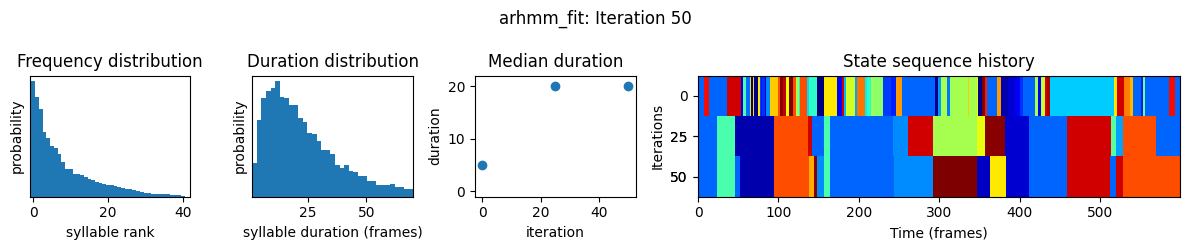

100%|███████████████████████████████████| 51/51 [02:20<00:00,  2.75s/it]


In [40]:
num_ar_iters = 50

model_name = 'arhmm_fit'
model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    model_name = model_name,
    ar_only=True, num_iters=num_ar_iters)

Outputs will be saved to /home/kaf200/datta/kai/mph/moseq-
explore/kpms_projects/blscale_wk3_to52/slds_fit


  5%|█▋                                | 25/501 [01:53<36:07,  4.55s/it]

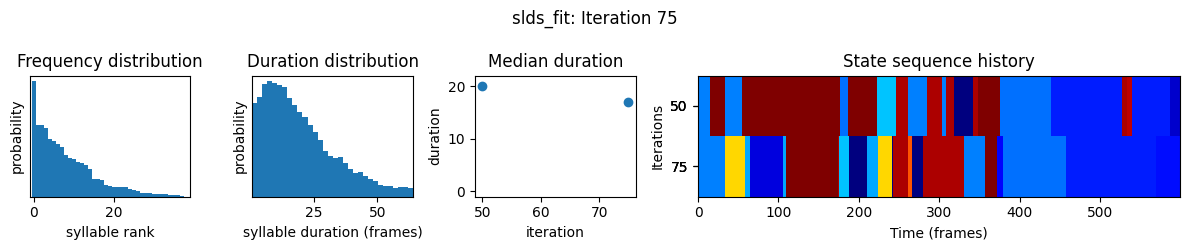

 10%|███▍                              | 50/501 [03:48<33:59,  4.52s/it]

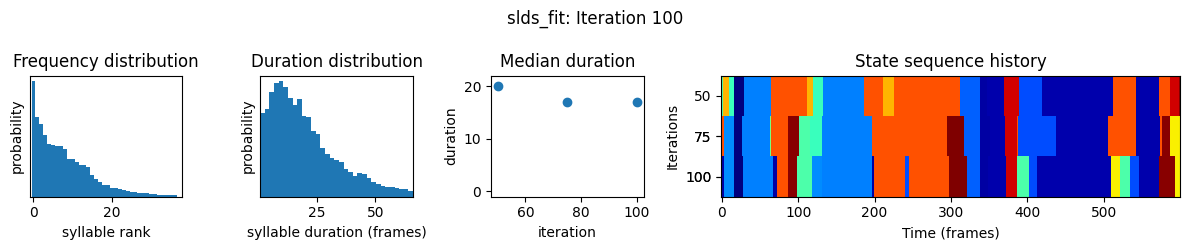

 15%|█████                             | 75/501 [05:43<32:09,  4.53s/it]

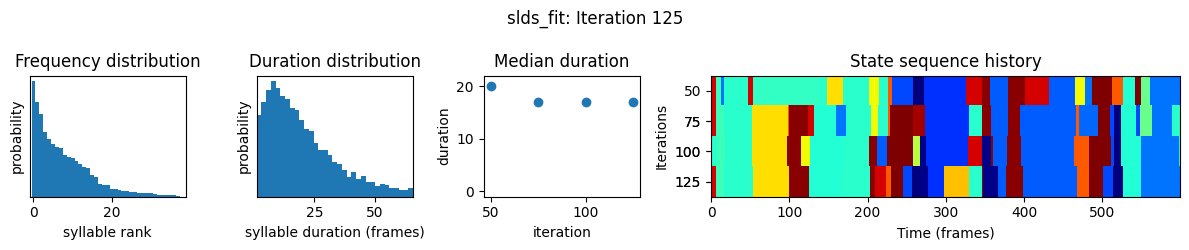

 20%|██████▌                          | 100/501 [07:37<30:16,  4.53s/it]

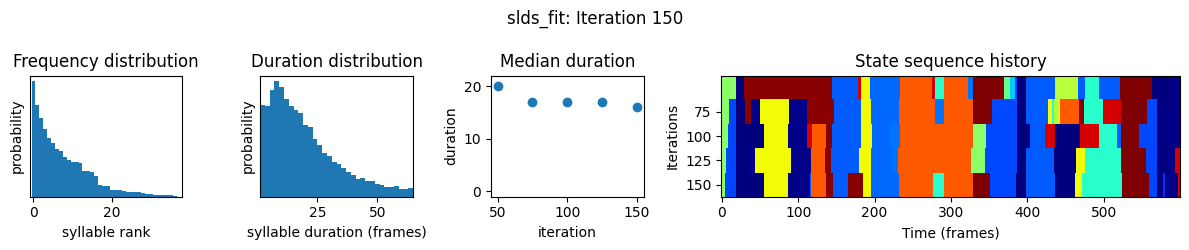

 25%|████████▏                        | 125/501 [09:32<28:23,  4.53s/it]

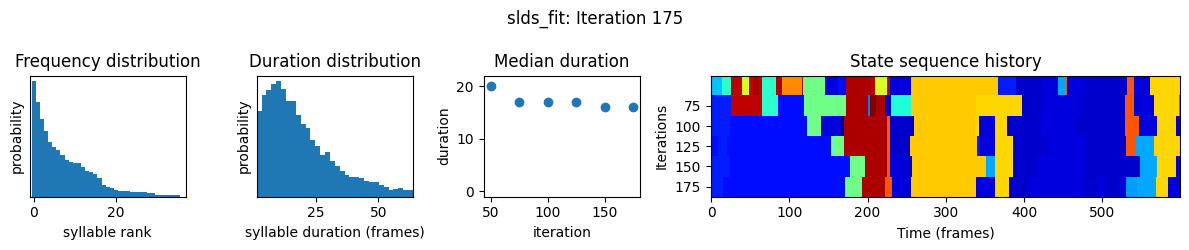

 30%|█████████▉                       | 150/501 [11:27<26:30,  4.53s/it]

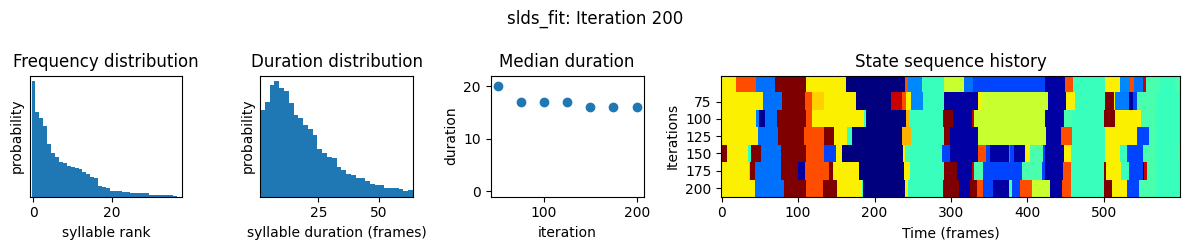

 35%|███████████▌                     | 175/501 [13:21<24:36,  4.53s/it]

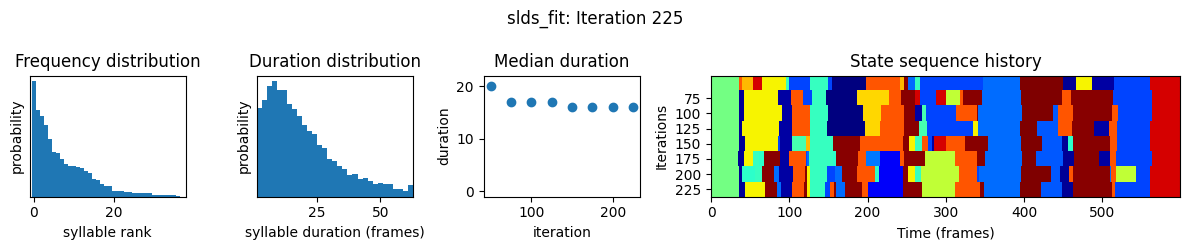

 40%|█████████████▏                   | 200/501 [15:16<22:47,  4.54s/it]

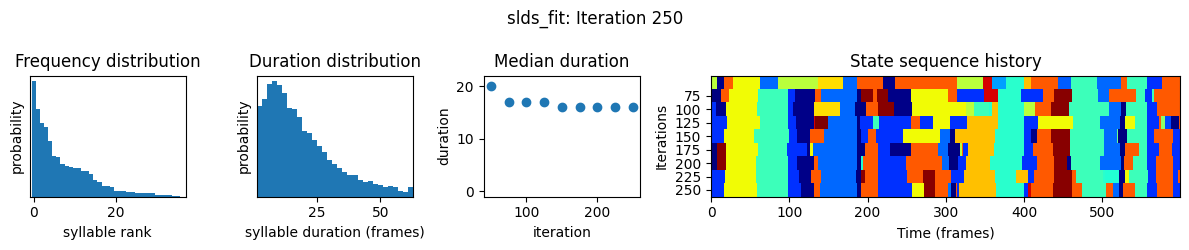

 45%|██████████████▊                  | 225/501 [17:11<20:51,  4.53s/it]

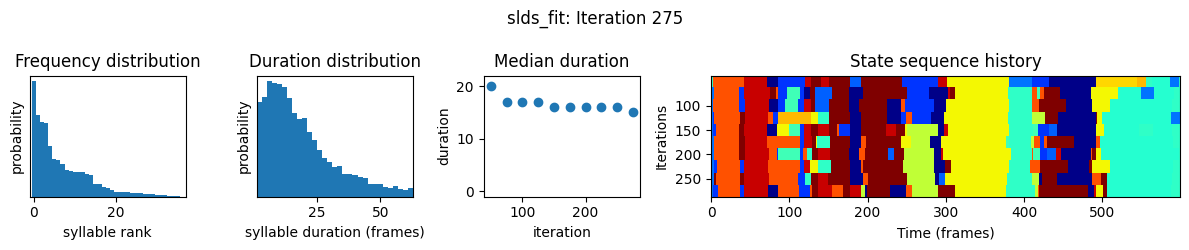

 50%|████████████████▍                | 250/501 [19:06<18:57,  4.53s/it]

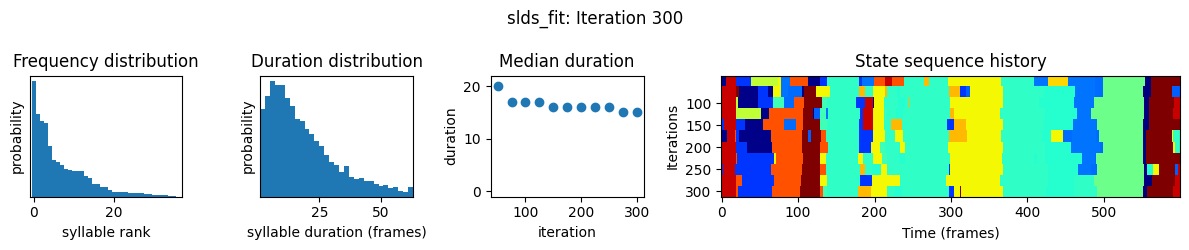

 55%|██████████████████               | 275/501 [21:01<17:04,  4.53s/it]

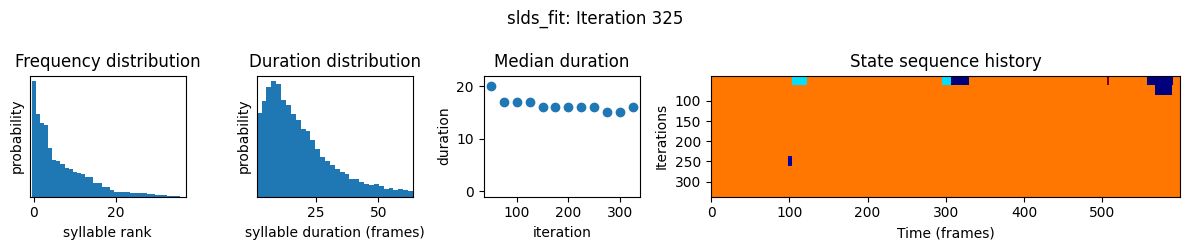

 60%|███████████████████▊             | 300/501 [22:55<15:10,  4.53s/it]

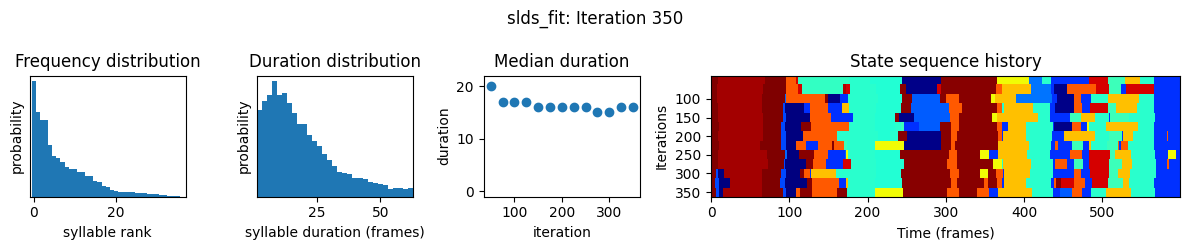

 65%|█████████████████████▍           | 325/501 [24:50<13:17,  4.53s/it]

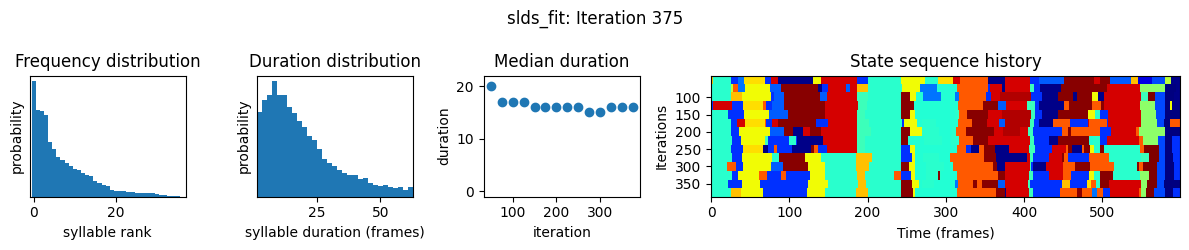

 70%|███████████████████████          | 350/501 [26:45<11:24,  4.53s/it]

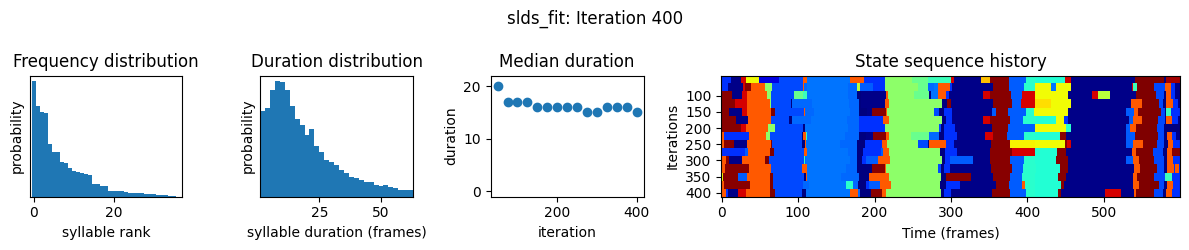

 75%|████████████████████████▋        | 375/501 [28:40<09:31,  4.54s/it]

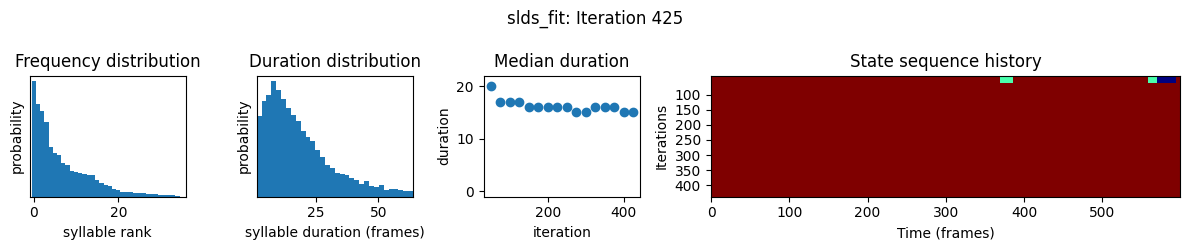

 79%|██████████████████████████▏      | 398/501 [30:26<07:49,  4.56s/it]

In [ ]:
# load model checkpoint
model_name = 'arhmm_fit'
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 200 iters
new_model_name = "slds_fit"
model = kpms.fit_model(
    model, data, metadata, project_dir, new_model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500,
    parallel_message_passing = True)[0]
    

In [33]:
model_name = 'slds_fit'
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=550)

results = kpms.extract_results(
    model, metadata, project_dir, model_name,
    save_results = False)
jl.dump(results, f'{results_dir()}/pop-results.p');